In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [34]:
def createGreenTaxiDataset(year):
  dfs = []
  for i in range(1,13):
    df = pd.read_parquet(f'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_{year}-{str(i).zfill(2)}.parquet')
    dfs.append(df)
  
  return pd.concat(dfs)

In [35]:
df = createGreenTaxiDataset(2021)

In [36]:
def getTripDuration(df):
  df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).apply(lambda x: x.total_seconds() / 60)
  return df

In [37]:
df = getTripDuration(df)
df = df.loc[(df.duration > 0) & (df.duration <= 60)]

<Axes: xlabel='duration', ylabel='Count'>

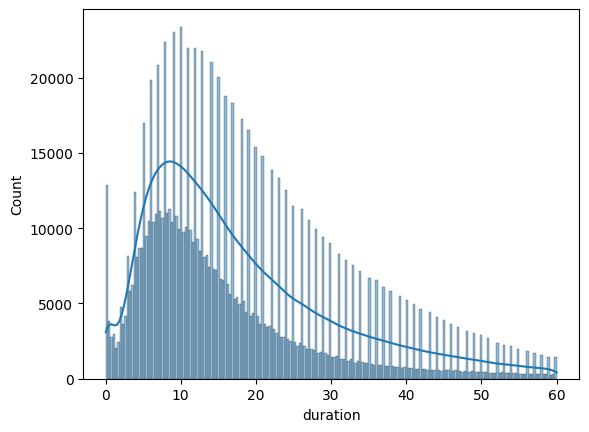

In [38]:
sns.histplot(df, x='duration', kde=True)

In [39]:
def formatTrainingInputs(df):
  df['PU_DO'] = df.PULocationID.astype(str).str.cat(df.DOLocationID.astype(str)) 

  # define input types
  numerical = ['trip_distance']
  categorical = ['PU_DO']
  df[categorical] = df[categorical].astype(str)

  # one-hot encoding for categorical variables
  df_dicts = df[categorical + numerical].to_dict(orient='records')
  dv = DictVectorizer()
  X = dv.fit_transform(df_dicts)

  return X


In [40]:
def prepareModelInputs(df):
  X = formatTrainingInputs(df)
  y = df.duration
  
  splits = train_test_split(X, y, train_size=.7, random_state=42)

  return {
    'X_train': splits[0],
    'X_test': splits[1],
    'y_train': splits[2],
    'y_test': splits[3]
  }

In [41]:
splits = prepareModelInputs(df)

In [42]:
def trainTestModel(model, splits):
  model.fit(splits['X_train'], splits['y_train'])
  y_preds = model.predict(splits['X_test'])
  
  print("Mean Squared Error (test): ", round(mean_squared_error(y_preds, splits['y_test'], squared=False),2))

  sns.histplot(splits['y_test'], kde=True)
  sns.histplot(y_preds, kde=True)


/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Squared Error (test):  8.66


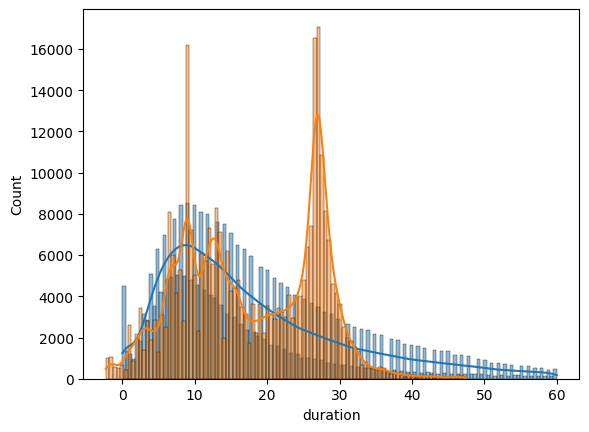

In [43]:
trainTestModel(LinearRegression(), splits)

/Users/bastienwinant/Desktop/projects/mlops-zoomcamp/.env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Squared Error (test):  8.66


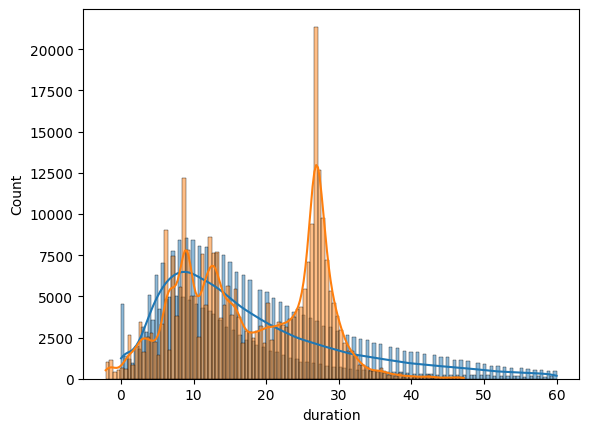

In [44]:
trainTestModel(Ridge(), splits)

In [ ]:
trainTestModel(Lasso(), splits)